In [194]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
display.set_matplotlib_formats('svg')

In [195]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
data = pd.read_csv(url,sep=',',header=None)

In [196]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,10,13
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


In [197]:
data[13].unique()

array([0, 2, 1, 3, 4])

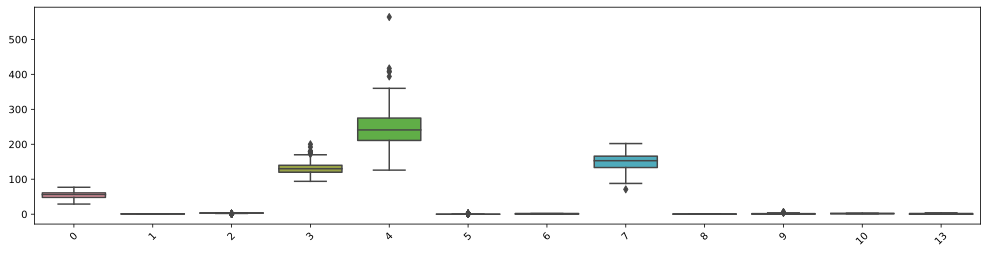

In [198]:
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [199]:
data = data.drop(data[data[11]=="?"].index)
data = data.drop(data[data[12]=="?"].index)

data[11] = pd.to_numeric(data[11])
data[12] = pd.to_numeric(data[12])

data = data[data[4]<350]
data = data[data[7]>75]
data = data[data[3]<175]

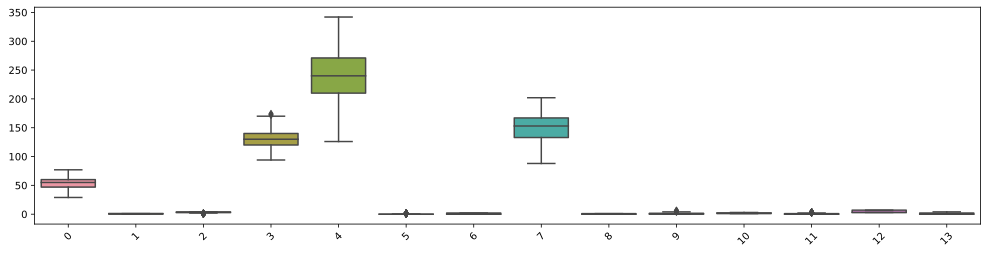

In [200]:
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [201]:
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop(13)
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data[14] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data[14][data[13]>0] = 1

<ipython-input-201-53169f4430e9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[14][data[13]>0] = 1


In [202]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data[14].values ).float()
labels = labels[:,None] # transform to matrix

In [203]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)


# train and test dataloaders
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)

In [204]:
dataT.size()

torch.Size([281, 13])

In [205]:
# create a class for the model WITH BATCH NORM

class ANNwine_withBNorm(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(13,16)
    
    ### hidden layers
    self.fc1    = nn.Linear(16,32)
    self.bnorm1 = nn.BatchNorm1d(16) # the number of units into this layer
    self.fc2    = nn.Linear(32,20)
    self.bnorm2 = nn.BatchNorm1d(32) # the number of units into this layer

    ### output layer
    self.output = nn.Linear(20,1)
  
  # forward pass
  def forward(self,x,doBN):

    # input (x starts off normalized)
    x = F.relu( self.input(x) )


    if doBN:
      # hidden layer 1
      x = self.bnorm1(x) # batchnorm
      x = self.fc1(x)    # weighted combination
      x = F.relu(x)      # activation function

      # hidden layer 2
      x = self.bnorm2(x) # batchnorm
      x = self.fc2(x)    # weighted combination
      x = F.relu(x)      # activation function
    

    else:
      # hidden layer 1
      x = F.relu( self.fc1(x) )

      # hidden layer 2
      x = F.relu( self.fc2(x) )

    # output layer
    return self.output(x)

In [247]:
# a function that trains the model

# global parameter
numepochs = 100

def trainTheModel(doBN=True):

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(winenet.parameters(),lr=.0001)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X,doBN)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      #print(torch.sigmoid(yHat))
      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((torch.sigmoid(yHat)>.5) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)



    ### test accuracy

    # NOTE: batch normalization should be turned off during testing, so we definitely need to switch modes here
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X,doBN)
    testAcc.append( 100*torch.mean(((torch.sigmoid(yHat)>.5) == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses

In [245]:

# create and train a model WITH BATCHNORM
winenet = ANNwine_withBNorm()
trainAccWith,testAccWith,lossesWith = trainTheModel(True)


tensor([[0.4190],
        [0.4701],
        [0.5209],
        [0.4986],
        [0.5014],
        [0.5247],
        [0.4972],
        [0.4700],
        [0.4870],
        [0.5395],
        [0.4921],
        [0.5112],
        [0.4696],
        [0.4860],
        [0.4664],
        [0.4593],
        [0.5707],
        [0.5711],
        [0.5926],
        [0.4701],
        [0.5276],
        [0.5078],
        [0.4461],
        [0.5029],
        [0.5206],
        [0.4196],
        [0.5355],
        [0.4859],
        [0.5353],
        [0.4766],
        [0.5205],
        [0.4857]], grad_fn=<SigmoidBackward0>)
tensor([[0.4798],
        [0.4779],
        [0.5621],
        [0.5717],
        [0.4847],
        [0.4761],
        [0.4838],
        [0.4745],
        [0.5310],
        [0.4848],
        [0.5267],
        [0.4898],
        [0.5145],
        [0.5489],
        [0.5275],
        [0.4888],
        [0.5424],
        [0.5211],
        [0.5227],
        [0.5686],
        [0.4358],
        [0.4467],

tensor([[0.4943],
        [0.5230],
        [0.4595],
        [0.5387],
        [0.4878],
        [0.4391],
        [0.5249],
        [0.5102],
        [0.4701],
        [0.4753],
        [0.4829],
        [0.4594],
        [0.5343],
        [0.5404],
        [0.5702],
        [0.5222],
        [0.5098],
        [0.5138],
        [0.4756],
        [0.5279],
        [0.4322],
        [0.4896],
        [0.4054],
        [0.5206],
        [0.3696],
        [0.5517],
        [0.5027],
        [0.5431],
        [0.5139],
        [0.4851],
        [0.5233],
        [0.4707]], grad_fn=<SigmoidBackward0>)
tensor([[0.5113],
        [0.5060],
        [0.5269],
        [0.4330],
        [0.4928],
        [0.5410],
        [0.5147],
        [0.5500],
        [0.4821],
        [0.4743],
        [0.4408],
        [0.5410],
        [0.4505],
        [0.4881],
        [0.3974],
        [0.4435],
        [0.4309],
        [0.5238],
        [0.5238],
        [0.4324],
        [0.4828],
        [0.4798],

tensor([[0.5098],
        [0.4725],
        [0.5284],
        [0.5037],
        [0.5387],
        [0.5176],
        [0.5837],
        [0.4248],
        [0.3857],
        [0.5028],
        [0.5138],
        [0.4406],
        [0.5383],
        [0.3735],
        [0.5775],
        [0.5268],
        [0.5242],
        [0.4196],
        [0.3206],
        [0.4548],
        [0.4591],
        [0.4196],
        [0.5191],
        [0.3107],
        [0.5321],
        [0.5206],
        [0.4194],
        [0.5658],
        [0.5344],
        [0.5353],
        [0.4518],
        [0.4884]], grad_fn=<SigmoidBackward0>)
tensor([[0.4558],
        [0.3501],
        [0.4873],
        [0.5496],
        [0.5528],
        [0.4813],
        [0.3906],
        [0.4725],
        [0.5296],
        [0.4781],
        [0.5254],
        [0.5133],
        [0.5818],
        [0.5647],
        [0.4725],
        [0.5457],
        [0.5056],
        [0.4576],
        [0.4073],
        [0.3473],
        [0.3297],
        [0.5308],

tensor([[0.5603],
        [0.5319],
        [0.5504],
        [0.4046],
        [0.3804],
        [0.5656],
        [0.4103],
        [0.5910],
        [0.6395],
        [0.6177],
        [0.4413],
        [0.3759],
        [0.3978],
        [0.5022],
        [0.4681],
        [0.4219],
        [0.2309],
        [0.4607],
        [0.2969],
        [0.4943],
        [0.6039],
        [0.3790],
        [0.5515],
        [0.6087],
        [0.5389],
        [0.5526],
        [0.5509],
        [0.4293],
        [0.6104],
        [0.3178],
        [0.2018],
        [0.3675]], grad_fn=<SigmoidBackward0>)
tensor([[0.5638],
        [0.5265],
        [0.6001],
        [0.4507],
        [0.4001],
        [0.5125],
        [0.4015],
        [0.6032],
        [0.3297],
        [0.4742],
        [0.5623],
        [0.3184],
        [0.4571],
        [0.6037],
        [0.5235],
        [0.5120],
        [0.4437],
        [0.4140],
        [0.4776],
        [0.5010],
        [0.4994],
        [0.4949],

tensor([[0.1800],
        [0.4855],
        [0.6272],
        [0.3495],
        [0.5440],
        [0.6435],
        [0.1705],
        [0.6224],
        [0.4076],
        [0.5076],
        [0.5758],
        [0.3284],
        [0.2576],
        [0.6306],
        [0.3322],
        [0.6377],
        [0.6138],
        [0.3013],
        [0.5373],
        [0.3950],
        [0.2288],
        [0.6210],
        [0.3375],
        [0.4455],
        [0.6206],
        [0.4511],
        [0.3834],
        [0.5410],
        [0.4802],
        [0.6022],
        [0.6487],
        [0.3945]], grad_fn=<SigmoidBackward0>)
tensor([[0.4803],
        [0.3688],
        [0.5943],
        [0.6032],
        [0.3984],
        [0.6508],
        [0.3811],
        [0.6326],
        [0.5299],
        [0.4442],
        [0.4232],
        [0.6444],
        [0.1582],
        [0.6099],
        [0.5215],
        [0.6306],
        [0.2757],
        [0.2862],
        [0.6437],
        [0.5204],
        [0.1479],
        [0.2055],

tensor([[0.4077],
        [0.4078],
        [0.2227],
        [0.1401],
        [0.6853],
        [0.6728],
        [0.3750],
        [0.4564],
        [0.2762],
        [0.5277],
        [0.7148],
        [0.6632],
        [0.2611],
        [0.3819],
        [0.4282],
        [0.6728],
        [0.4777],
        [0.6984],
        [0.1582],
        [0.3155],
        [0.6175],
        [0.3047],
        [0.1980],
        [0.7192],
        [0.6224],
        [0.5269],
        [0.2814],
        [0.6926],
        [0.3189],
        [0.1924],
        [0.5750],
        [0.4343]], grad_fn=<SigmoidBackward0>)
tensor([[0.6602],
        [0.5007],
        [0.5029],
        [0.4250],
        [0.4800],
        [0.5327],
        [0.3664],
        [0.5014],
        [0.6042],
        [0.7055],
        [0.3426],
        [0.3706],
        [0.2820],
        [0.6248],
        [0.3310],
        [0.6591],
        [0.2427],
        [0.5812],
        [0.4745],
        [0.6317],
        [0.2694],
        [0.7131],

tensor([[0.7722],
        [0.3571],
        [0.4997],
        [0.1471],
        [0.2337],
        [0.6709],
        [0.4227],
        [0.2932],
        [0.5201],
        [0.1246],
        [0.5398],
        [0.1364],
        [0.2885],
        [0.4465],
        [0.7719],
        [0.6545],
        [0.5257],
        [0.1324],
        [0.5707],
        [0.6228],
        [0.3914],
        [0.7000],
        [0.3027],
        [0.7425],
        [0.2462],
        [0.6936],
        [0.1932],
        [0.1514],
        [0.5386],
        [0.3295],
        [0.6796],
        [0.7062]], grad_fn=<SigmoidBackward0>)
tensor([[0.5160],
        [0.4520],
        [0.7087],
        [0.1577],
        [0.2642],
        [0.1804],
        [0.6603],
        [0.3636],
        [0.0857],
        [0.1552],
        [0.2065],
        [0.6751],
        [0.6241],
        [0.7149],
        [0.4957],
        [0.5335],
        [0.3108],
        [0.5702],
        [0.7159],
        [0.5207],
        [0.3558],
        [0.4732],

tensor([[0.4072],
        [0.6269],
        [0.1398],
        [0.0545],
        [0.1949],
        [0.2400],
        [0.7084],
        [0.2134],
        [0.0276],
        [0.6928],
        [0.2138],
        [0.7508],
        [0.2449],
        [0.5763],
        [0.5762],
        [0.6761],
        [0.1213],
        [0.4588],
        [0.4799],
        [0.6908],
        [0.7611],
        [0.8216],
        [0.2684],
        [0.1287],
        [0.4427],
        [0.6789],
        [0.1755],
        [0.7462],
        [0.6605],
        [0.3924],
        [0.7223],
        [0.6475]], grad_fn=<SigmoidBackward0>)
tensor([[0.4566],
        [0.2502],
        [0.7726],
        [0.7514],
        [0.3479],
        [0.7873],
        [0.0575],
        [0.1337],
        [0.2746],
        [0.2278],
        [0.3611],
        [0.6795],
        [0.5359],
        [0.5265],
        [0.2271],
        [0.2724],
        [0.8224],
        [0.7736],
        [0.0516],
        [0.3150],
        [0.2672],
        [0.2362],

tensor([[0.1122],
        [0.0379],
        [0.2366],
        [0.5166],
        [0.8180],
        [0.7980],
        [0.2575],
        [0.8300],
        [0.5868],
        [0.7550],
        [0.4694],
        [0.8518],
        [0.2229],
        [0.1300],
        [0.1321],
        [0.7766],
        [0.3698],
        [0.3076],
        [0.5435],
        [0.0340],
        [0.5278],
        [0.3353],
        [0.6585],
        [0.7729],
        [0.2779],
        [0.2782],
        [0.7545],
        [0.6598],
        [0.7092],
        [0.5825],
        [0.0343],
        [0.4507]], grad_fn=<SigmoidBackward0>)
tensor([[0.1775],
        [0.1356],
        [0.1954],
        [0.0696],
        [0.3705],
        [0.1384],
        [0.1461],
        [0.3727],
        [0.8220],
        [0.7953],
        [0.6408],
        [0.7453],
        [0.4900],
        [0.7853],
        [0.7888],
        [0.1278],
        [0.3126],
        [0.3034],
        [0.8110],
        [0.0686],
        [0.7551],
        [0.4776],

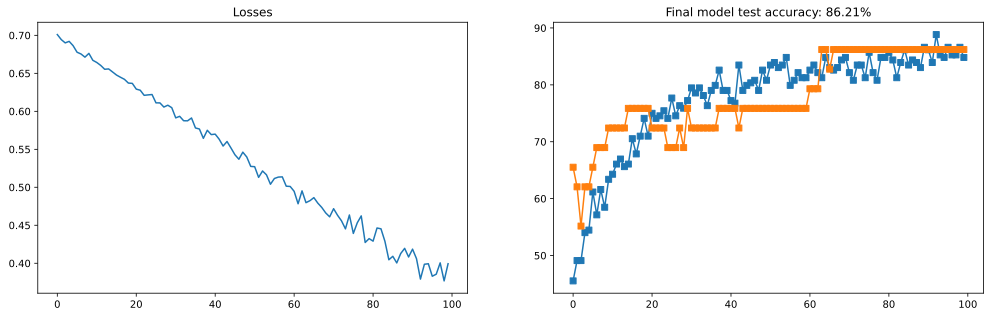

In [246]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(17,5))

ax[0].plot(lossesWith,label='WITH batchnorm')

ax[0].set_title('Losses')
#ax[0].legend()

ax[1].plot(trainAccWith,'s-')
ax[1].plot(testAccWith,'s-')
ax[1].set_title(f'Final model test accuracy: {testAccWith[-1]:.2f}%')
#ax[1].legend()


plt.show()